In [1]:
import numpy as np                 # for numerical operations
import matplotlib.pyplot as plt    # for plotting
import pandas as pd                # for data manipulation
import datetime as dt              # for converting to datetime
import cartopy.crs as ccrs         # for plotting cartopy figures
import cartopy.feature as cfeature # for adding map features
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER # to format lat and lon
from scipy import stats            # for linear regression calculation

# Impact of Climate Change on Alaskan Salmon  

**Rachel Ha**  

OCEAN 215 Final Project  
Autumn 2024

## Introduction

<!-- Include your motivation and any background information needed to understand your research question and data analysis. Clearly state your research question and hypothesis. -->

Salmon is considered a key species essential in balancing the ecosystem. They help keep the ecosytem in balance with their migration habits. As they mature, they migrate downstream to the open ocean but return upstream to lakes or rivers to reproduce. Since salmon are susceptible to changes in habitats, their migration patterns may be disrupted by climate change. Being one of the biggest commercial salmon fishing industries, Alaska is heavily dependent on the livelihood of salmon, and thus I decided to investigate changes in salmon population in the Alaskan region specifically. 

I am investigating how the change in sea ice extent can affect Alaskan salmon populations, specifically Coho salmon and Fall Chum salmon, in the Lower Yukon Area between 1990 and 2021. My hypothesis is that decreasing sea ice extent in the northern hemisphere and a thinner ice thickness in Shageluk Lake correlate to a fall in Alaskan salmon populations. This is because the increasing temperatures from global warming would cause ice sheets to melt (so reduce sea ice extent or thinner ice thickness). The meltwater runoff into the Lower Yukon River would then decrease the temperature, reducing the dissolved oxygen levels (as the freshwater dilutes the original DO in the river) and affecting migration patterns of both salmon populations, causing salmon populations to be unable to thrive and drop.

## Data sources:
<!-- List each data source used in your project. For each dataset, include: 
     - Where you accessed it from 
     - Date you accessed/downloaded it 
     - Data collection process
     - Relevant variables (including unit) 
     - Spatial and temporal coverage and resolution 
     - Description of any obstacles or challenges you faced in obtaining the dataset
     - URL to the dataset if available -->

- Dataset 1: Sea Ice Extent and Climatology data in North Hemisphere
  - Downloaded from National Snow and Ice Data Center on 2024-11-15
  - Data collection process: Data collected using the Scanning Multi-channel Microwave Radiometer (SMMR) instrument on the Nimbus-7 platform and from a series of Special Sensor Microwave Imager (SSM/I) and Special Sensor Microwave Imager/Sounder (SSMIS) instruments on the Defense Meteorological Satellite Program (DMSP) satellites. All these satellites were used to collect data through different time intervals. 
  - Relevant variables included:
      - Sea Ice Extent (10^6 sq km)
      - Year, Month, Date 
  - Spatial coverage and resolution: 90&deg;N 30.98&deg;S 180&deg;E -180&deg;W, 25km x 25km
  - Temporal coverage and resolution: 1978-2024, daily 
  - Obstacles to data access: 
  - URL to dataset: https://nsidc.org/data/g02135/versions/3 
<br>

- Dataset 2: Observed Ice Thickness in Shageluk Lake
  - Downloaded from National Science Foundation Arctic Data Center on 2024-11-18
  - Data collection process: No sampling description provided. Waterbodies were selected based on available late winter ice observations for multiple years and proximate air temperature during the same period of ice observations.
  - Relevant variables included:
      - Water Body Name - Shageluk Lake
      - Observed Ice Thickness (cm)
      - Year (YYYY)
  - Spatial coverage and resolution: 72&deg;N 54&deg;S -131&deg;E -177&deg;W, resolution not specified
  - Temporal coverage and resolution: 1962-2019, yearly
  - Obstacles to data access: This dataset primarily looks at the Maximum Ice Thickness calculated by the Stefan ice growth model, so when there are multiple data values for Observed Ice Thickness in one year, it doesn't show all values and only shows "multiple". Luckily, I found out the Shageluk Lake data I needed to use didn't have such problem. It was missing a value for one year, but it was solved by interpolation. 
  - URL to dataset: https://arcticdata.io/catalog/view/doi%3A10.18739%2FA26688J9Z 
<br>
  
- Dataset 3: Coho Salmon and Fall Chum Salmon Catch-Per-Unit-Effort data in Lower Yukon, Alaska
  - Downloaded from Alaska Department of Fish and Game on 2024-11-13
  - Data collection process: Not specifed
  - Relevant variables included: 
      - CPUE (Catch-Per-Unit-Effort)
      - Time
  - Spatial coverage and resolution: Lower Yukon Management Area, resolution not specified
  - Temporal coverage and resolution: 1988-2024, daily (between July to September)
  - Obstacles to data access: There is not a extensive description of the dataset so it was hard to understand how the data is being read, especially with some data points as 0, I'm not sure if it was a measurement error or simply there wasn't data. 
  - URL to dataset: https://www.adfg.alaska.gov/index.cfm?adfg=commercialbyareayukon.salmon_testfishdata
<br>

## 1. Finding the Correlation and Linear Regression between Sea Ice Extent and Salmon Population 
<!-- In this cell, introduction the data set(s) you are working with, specify which aspect of your research question this section addresses, and describe the figure you will produce. -->
I will be using sea ice extent data (dataset 1) and salmon population data (dataset 3) to find their correlation, and also to plot a linear regression line to show the overall trend of each dataset. The trend of the sea ice extent will support my underlying assumption that sea ice extent is decreasing due to climate change, so it should be showing a negative linear regression. For the salmon populations, since I hypothesised that the salmon populations would decrease as the sea ice extent decreases, I would also expect to see a negative linear regression. The two datasets should have a high correlation, with a number closer to 1. 

In [2]:
# load data file(s)
ice_filepath = "N_seaice_extent_daily_v3.0.csv"
ice_df = pd.read_csv(ice_filepath, skiprows=[1]) #need to skip first row 

coho_df = pd.read_csv('cohosalmon_count.csv')
fallchum_df = pd.read_csv('fallchum_count.csv')

# as part of commenting your code throughout this section, discuss any problems you encountered and how you solved them

In [3]:
# perform data cleaning steps

#for ice_df

#im not sure why but my jupyter notebook doesn't quite like the "Year" column for the ice_df and would refuse to run unless i display ice_df before cleaning the dataset
display(ice_df)
# print(ice_df.columns)

#combine year month day columns
ice_df['Time'] = pd.to_datetime(ice_df['Year'].astype(str) + "-" +
                                ice_df[' Month'].astype(str) + "-" + ice_df[' Day'].astype(str),
                                      format='%Y-%m-%d')

#extract needed data (1990-2021)
ice_df = ice_df[(ice_df['Time'] >= '1990-01-01') & (ice_df['Time'] <= '2021-12-31')]

#had to check the names of the columns since i keep getting an error that the column is not found (spacing issues)
#print(ice_df.columns)

#remove unused columns (Missing, Source Data)
ice_df = ice_df.drop(['Year', ' Month', ' Day', '    Missing', ' Source Data'], axis = 1)

#set time as the index column
ice_df.set_index('Time', inplace=True)

#extract ice data between july to sep since those are the months where salmon count data are collected
fall_ice_df = ice_df[(ice_df.index.month >= 7) & (ice_df.index.month <= 9)]


#for coho_df
#convert date column to datetime
#Date Kog in MM/DD format -> combine Sample Year to make Y/M/D
coho_df['Date Kog.'] = pd.to_datetime(coho_df['Sample Year'].astype(str) + "-" + coho_df['Date Kog.'],
                                      format='%Y-%m/%d')

# name date year new column
coho_df['Time'] = coho_df['Date Kog.']

#sort by dateyear
coho_df = coho_df.sort_values("Time")

#set 'Time' as index
coho_df = coho_df.set_index('Time')

# drop columns (Species, Run, Project, Date Kog., Sample Year)
coho_df = coho_df.drop(["Date Kog.","Sample Year","Species", "Run", "Project"], axis =1)


#for fallchum_df
fallchum_df['Date Kog.'] = pd.to_datetime(fallchum_df['Sample Year'].astype(str) + "-" + fallchum_df['Date Kog.'],
                                      format='%Y-%m/%d')
fallchum_df['Time'] = fallchum_df['Date Kog.']
fallchum_df = fallchum_df.sort_values("Time")
fallchum_df = fallchum_df.set_index('Time')
fallchum_df = fallchum_df.drop(["Date Kog.","Sample Year","Species", "Run", "Project"], axis =1)

,Year,Month,Day,Extent,Missing,Source Data
0,1978,10,26,10.231,0.0,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.26/nt_19...
1,1978,10,28,10.420,0.0,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.28/nt_19...
2,1978,10,30,10.557,0.0,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.30/nt_19...
3,1978,11,1,10.670,0.0,['/ecs/DP1/PM/NSIDC-0051.001/1978.11.01/nt_19...
4,1978,11,3,10.777,0.0,['/ecs/DP1/PM/NSIDC-0051.001/1978.11.03/nt_19...
...,...,...,...,...,...,...
15166,2024,11,16,9.195,0.0,['/ecs/DP4/PM/NSIDC-0081.002/2024.11.15/NSIDC0...
15167,2024,11,17,9.341,0.0,['/ecs/DP4/PM/NSIDC-0081.002/2024.11.16/NSIDC0...
15168,2024,11,18,9.404,0.0,['/ecs/DP4/PM/NSIDC-0081.002/2024.11.17/NSIDC0...
15169,2024,11,19,9.491,0.0,['/ecs/DP4/PM/NSIDC-0081.002/2024.11.18/NSIDC0...


In [4]:
# finding means 

#for ice_df
mean_ice_df = ice_df['     Extent'].groupby(ice_df.index.year).mean()


#for coho_df
#groupby(coho_df.index.year) to group years together and find the mean of the year
coho_annual_means = coho_df['Cumulative CPUE'].groupby(coho_df.index.year).mean()
#print(coho_annual_means)
#realised the data looks screwed (not all years have the number of same dates) 

#extract month day as variable to find common days 
coho_df['Month-Day'] = coho_df.index.strftime('%m-%d')

#groupby each year and find the unique month days 
days_per_year = coho_df.groupby(coho_df.index.year)['Month-Day'].unique()

#finding common days for all years
common_days = set(days_per_year.iloc[0])  # Start with days of the first year
for days in days_per_year[1:]:
    common_days.intersection_update(days) # found this function 

#convert the common days back to a sorted list
common_days = sorted(common_days)

# filter dataset to only include rows of common days 
filtered_coho_df = coho_df[coho_df['Month-Day'].isin(common_days)]

# calculate annual mean of Cumulative CPUE for common days
mean_coho = filtered_coho_df.groupby(filtered_coho_df.index.year)['Cumulative CPUE'].mean()


#for fallchum_df
#repeat steps from coho_df
fallchum_df['Month-Day'] = fallchum_df.index.strftime('%m-%d')
days_per_year = fallchum_df.groupby(fallchum_df.index.year)['Month-Day'].unique()
common_days = set(days_per_year.iloc[0])
for days in days_per_year[1:]:
    common_days.intersection_update(days) 
common_days = sorted(common_days)
filtered_fallchum_df = fallchum_df[fallchum_df['Month-Day'].isin(common_days)]
mean_fallchum = filtered_fallchum_df.groupby(filtered_fallchum_df.index.year)['Cumulative CPUE'].mean()


#more data filtering for linear regression plot for salmon populations 
#(since data before 2000 is skewed, a lot of values were 0 or close to zero, and i didn't realise that until i was making this figure) 
fallchum_2000 = mean_fallchum[(mean_fallchum.index.values >= 2000) & (mean_fallchum.index.values <= 2021)]
coho_2000 = mean_coho[(mean_coho.index.values >= 2000) & (mean_coho.index.values <=2021)]

In [5]:
# perform data analysis
# correlate ice_df (sea ice extent) and coho_df & fallchum_df
r = fall_ice_df['     Extent'].corr(coho_df["Cumulative CPUE"])
print('r^2 for coho:', r**2)

r = fall_ice_df['     Extent'].corr(fallchum_df["Cumulative CPUE"])
print('r^2 for fall chum:', r**2)

r^2 for coho: 0.40826886335629814
r^2 for fall chum: 0.5381342906566399


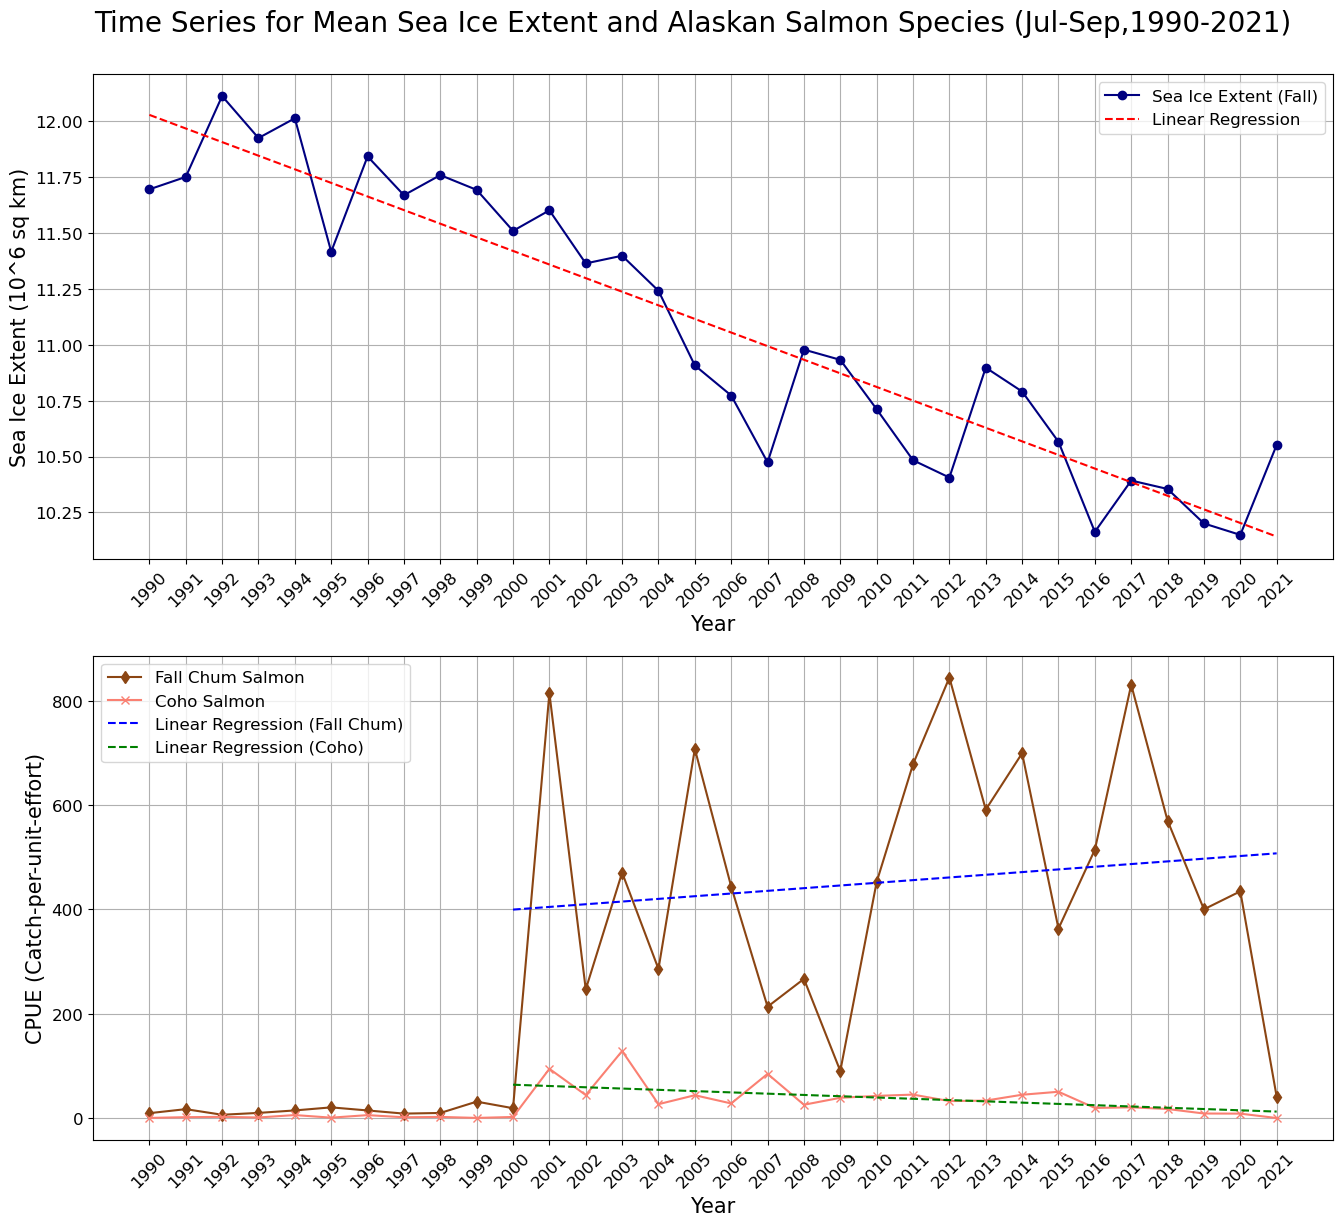

In [6]:
# make and display the first figure
# plot linear regression
fig, axs = plt.subplots(figsize=(16,13),nrows = 2)

# for top plot
#plot mean sea ice extent
axs[0].plot(mean_ice_df.index.values,mean_ice_df.values, #plot ice_df (daily resolution)
           c="navy",marker="o",label="Sea Ice Extent (Fall)") 

#linear regression
slope, intercept, rvalue, pvalue, stderr = stats.linregress(mean_ice_df.index.values,mean_ice_df.values)
y_trend = slope * mean_ice_df.index.values + intercept
axs[0].plot(mean_ice_df.index.values,y_trend,
            c="red",ls="--", label="Linear Regression")

axs[0].set_xlabel('Year', fontsize=15)
axs[0].set_ylabel('Sea Ice Extent (10^6 sq km)', fontsize=15)
axs[0].grid()
axs[0].legend(fontsize=12)
axs[0].set_xticks(range(1990,2022))
axs[0].tick_params(axis='x', rotation=45, labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)

# for bottom plot
axs[1].plot(mean_fallchum.index.values, mean_fallchum.values, # plot mean_fallchum 
           c="saddlebrown",marker="d",label="Fall Chum Salmon") 
axs[1].plot(mean_coho.index.values, mean_coho.values, # plot mean_coho
           c="salmon",marker="x",label="Coho Salmon") 

#linear regression
slope, intercept, rvalue, pvalue, stderr = stats.linregress(fallchum_2000.index.values, fallchum_2000.values)
y_trend = slope * fallchum_2000.index.values + intercept
axs[1].plot(fallchum_2000.index.values,y_trend,
            c="blue",ls="--", label="Linear Regression (Fall Chum)")

slope, intercept, rvalue, pvalue, stderr = stats.linregress(coho_2000.index.values, coho_2000.values)
y_trend = slope * coho_2000.index.values + intercept
axs[1].plot(coho_2000.index.values,y_trend,
            c="green",ls="--", label="Linear Regression (Coho)")

axs[1].set_xlabel('Year', fontsize=15)
axs[1].set_ylabel('CPUE (Catch-per-unit-effort)', fontsize=15)
axs[1].grid()
axs[1].legend(fontsize=12)
axs[1].set_xticks(range(1990,2022))
axs[1].tick_params(axis='x', rotation=45, labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)

# making title for both graphs 
fig.suptitle('Time Series for Mean Sea Ice Extent and Alaskan Salmon Species (Jul-Sep,1990-2021)', fontsize=20)
plt.subplots_adjust(top=0.93)

<!-- Describe how this figure helps address your research question. What patterns or insights can you observe? -->
**Figure 1 Caption:** On the top plot, you can see the annual mean sea ice extent between July and September has a negative regression line, showing the decreasing trend of sea ice extent. For the bottom plot, the fall chum salmon population is showing a slightly positive linear regression, while the coho salmon has a slightly negative linear regression. 

## 2. Comparing the Climatology data of Sea Ice Extent in North Hemisphere and Salmon Populations
<!-- In the introduction below, specify the data set(s) you are working with in this section, which aspect of your research question this section addresses, and the figure you will produce -->
I was looking at the climatology data, where sea ice extent is averaged daily throughout the years from 1981-2011, to see the seasonal trend of sea ice extent. And by plotting the climatology data with the salmon populations, I can visually see the correlation between the two on a yearly level, instead of throughout several decades. I also specifically looked at the fall season (where salmon population data is more focused on), to zoom in and see the trends during fall. The figures I am going to produce will help support my hypothesis by looking at the change in sea ice on a seasonal level. When there is lowest ice extent, I should be seeing a decrease in salmon population. 

In [7]:
# if a new dataset, load data and perform data cleaning steps
# otherwise, continue to data analysis and figure creation

#loading in climatology data 
climatology_filepath = "N_seaice_extent_climatology_1981-2010_v3.0.csv"
climatology_df = pd.read_csv(climatology_filepath, header=1)

#first row [0]/ header is std Years, so it's considered the only column
# need to get rid of that and set second row as header row
# extract only DOY and average extent

#climatology_df = climatology_df.loc["std Years = 1981-2010"].reset_index()
climatology_df = climatology_df.iloc[:,[0,1]]

#set "DOY" = index
climatology_df = climatology_df.set_index("DOY")
#display(climatology_df)

#using salmon population data that has been clean in part 1

In [8]:
# perform data analysis
# for this part, i didn't do any data analysis, only made two figures that compares the climatology and salmon population trends

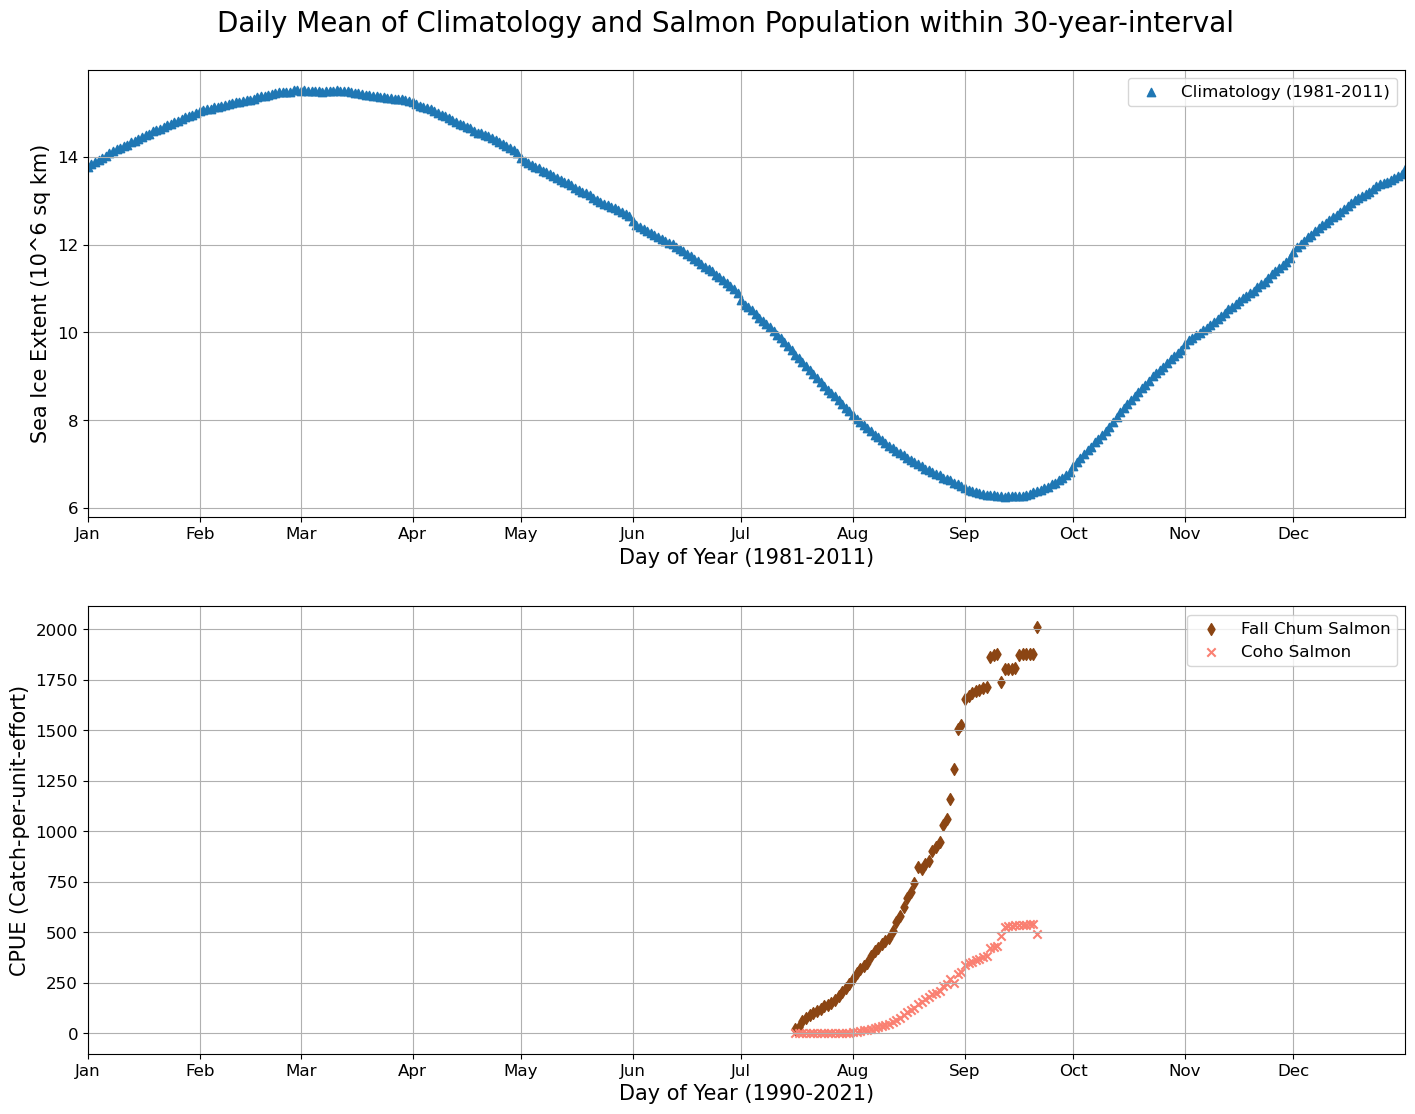

In [9]:
# make and display figure
fig, axs = plt.subplots(figsize=(17,12),nrows = 2)

#for climatology plot (top)
axs[0].scatter(climatology_df.index.values, climatology_df['   Average Extent'],
              marker="^", label="Climatology (1981-2011)")

axs[0].set_xlabel('Day of Year (1981-2011)', fontsize=15) 
axs[0].set_ylabel('Sea Ice Extent (10^6 sq km)', fontsize=15)

month_starts = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axs[0].set_xticks(month_starts, month_labels)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].set_xlim(1, 366)
axs[0].legend(fontsize=12)
axs[0].grid()

# plot fish count data on the bottom plot
# have to average out the data before plotting them (average daily data between 1981-2011)
dailymean_coho = coho_df.groupby(coho_df.index.dayofyear)['Cumulative CPUE'].mean()
#display(dailymean_coho)
dailymean_fallchum = fallchum_df.groupby(fallchum_df.index.dayofyear)['Cumulative CPUE'].mean()
#display(dailymean_fallchum)

axs[1].scatter(dailymean_fallchum.index, dailymean_fallchum.values,
               c="saddlebrown",marker="d",label="Fall Chum Salmon")
axs[1].scatter(dailymean_coho.index, dailymean_coho.values,
               c="salmon",marker="x",label="Coho Salmon")

#display whole year (all 12 months), but with data only between jul and september
axs[1].set_xlabel('Day of Year (1990-2021)', fontsize=15)
axs[1].set_ylabel('CPUE (Catch-per-unit-effort)', fontsize=15)
axs[1].set_xticks(month_starts, month_labels)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)
axs[1].set_xlim(1, 366)
axs[1].legend(fontsize=12)
axs[1].grid()

fig.suptitle('Daily Mean of Climatology and Salmon Population within 30-year-interval', fontsize=20)
plt.subplots_adjust(top=0.93)

<!-- Describe how this figure helps address your research question. What patterns or insights can you observe? -->
**Figure 2a Caption:** The top part of the plot shows the seasonal trend (climatology) of sea ice extent, where it peaks during spring (Feb-Apr) but bottoms during fall (Aug-Oct). The bottom graph shows the fall chum and coho CPUE, where both populations are showing an increasing trend with fall chum salmon increasing much greater than coho salmon during the fall season.

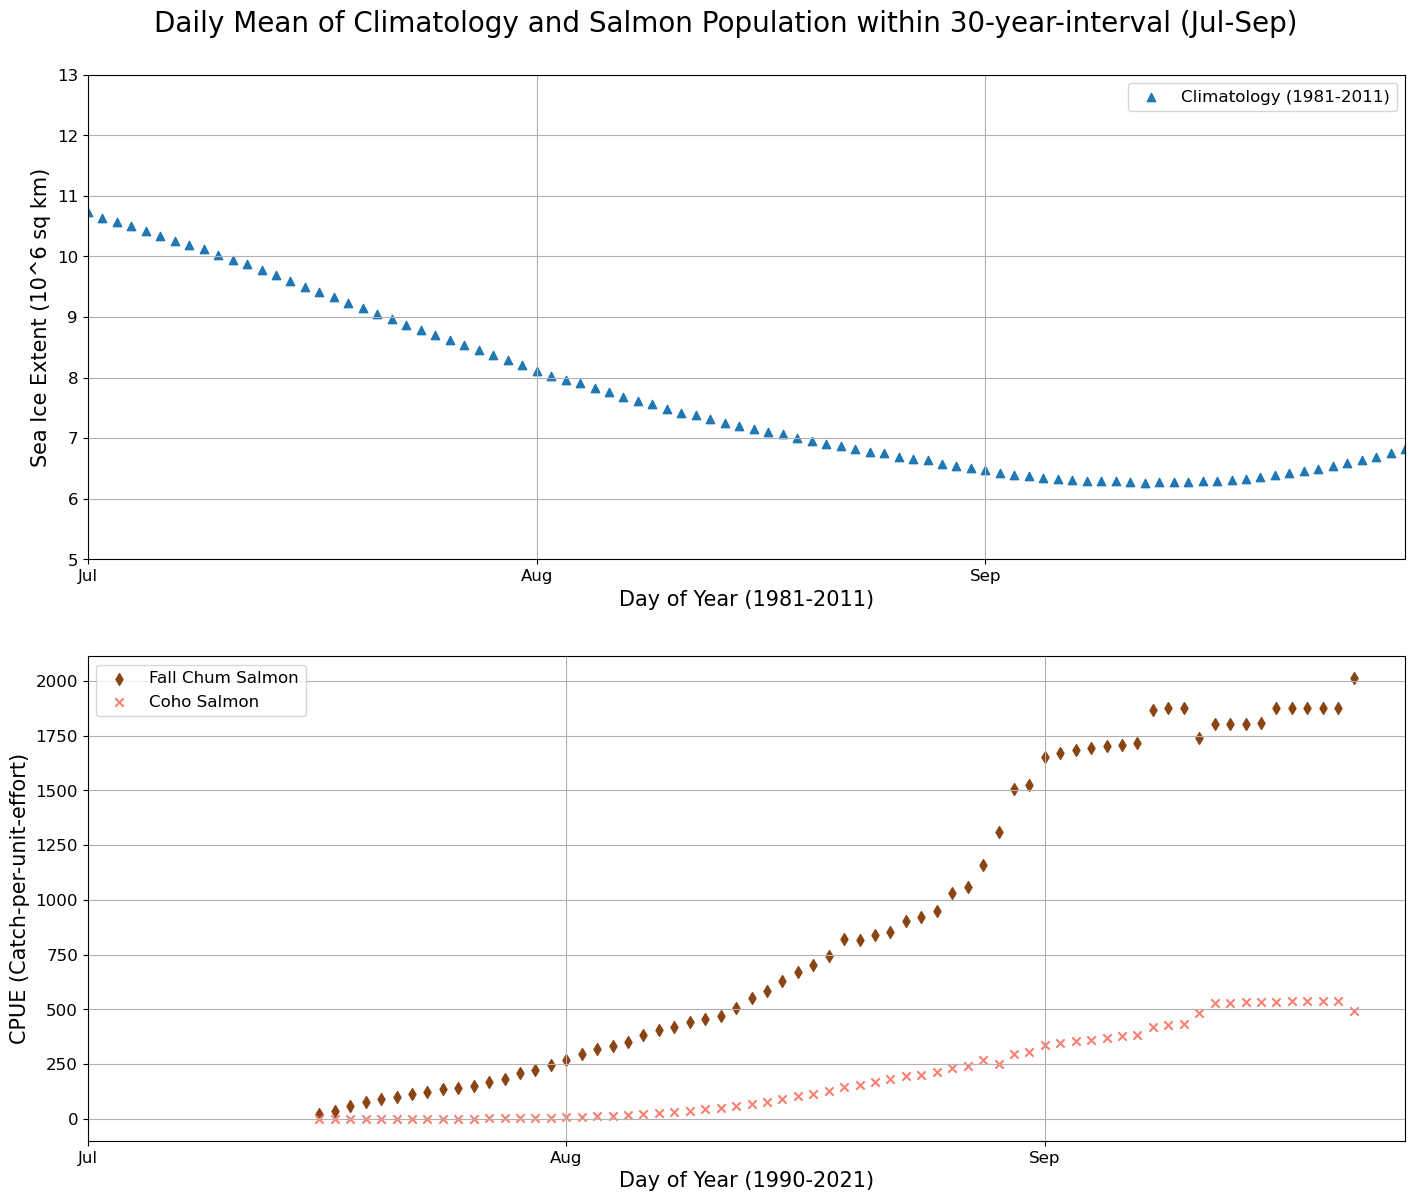

In [10]:
#separate graph just for daily mean salmon CPUE between jul to sep
fig, axs = plt.subplots(figsize=(17,13), nrows=2)
axs[0].scatter(climatology_df.index.values, climatology_df['   Average Extent'],
              marker="^", label="Climatology (1981-2011)")
axs[0].set_xlabel('Day of Year (1981-2011)', fontsize=15) 
axs[0].set_ylabel('Sea Ice Extent (10^6 sq km)', fontsize=15)
axs[0].set_xticks([182,213,244], ["Jul","Aug","Sep"])
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].set_xlim(182,273)
axs[0].set_ylim(5,13)
axs[0].legend(fontsize=12)
axs[0].grid()

axs[1].scatter(dailymean_fallchum.index, dailymean_fallchum.values,
               c="saddlebrown",marker="d",label="Fall Chum Salmon")
axs[1].scatter(dailymean_coho.index, dailymean_coho.values,
               c="salmon",marker="x",label="Coho Salmon")
axs[1].set_xlabel('Day of Year (1990-2021)', fontsize=15)
axs[1].set_ylabel('CPUE (Catch-per-unit-effort)', fontsize=15)
axs[1].set_xticks([182,213,244], ["Jul","Aug","Sep"])
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)
axs[1].legend(fontsize=12)
axs[1].grid()

fig.suptitle('Daily Mean of Climatology and Salmon Population within 30-year-interval (Jul-Sep)', fontsize=20)
plt.subplots_adjust(top=0.93)

<!-- Describe how this figure helps address your research question. What patterns or insights can you observe? -->
**Figure 2b Caption:** This figure is the same as figure 2a, but it is enlarged and looks at the fall months to better compare data since only data from July to September is available for salmon population. From the figure, you can see there is an inverse relationship between the sea ice extent and salmon populations in the fall, where both salmon population increases as sea ice extent decreases. 

## 3. Comparing the Linear Regression of Observed Ice Thickness in Shageluk Lake and Salmon Populations between 2003 and 2011
<!-- In the introduction below, specify the data set(s) you are working with in this section, which aspect of your research question this section addresses, and the figure you will produce -->

To be more specified to the Lower Yukon Region in Alaska, I will be comparing the linear regression lines of ice thickness in Shageluk Lake, which is located in the Lower Yukon region near to the Yukon River, and Salmon Populations. This dataset would help me look closer at the trends within the Lower Yukon region, as compared to figure 1 where it uses sea ice extent from the entire North Hemisphere, this dataset focuses on Shageluk ice thickness only. If the salmon population decreases as ice thickness decreases (assuming that ice thickness should be decreasing due to global warming), it will prove my hypothesis correct.

In [11]:
# if a new dataset, load data and perform data cleaning steps
# otherwise, continue to data analysis and figure creation

river_filepath = "AlaskaMaxIceThickness_lakes_rivers_1962_2019.csv"
river_data = pd.read_csv(river_filepath)
#display(river_data)

#extract shageluk data only
shageluk_data = river_data[river_data["StationName"] == "Shageluk"]
#display(shageluk_data)

#drop unused columns
shageluk_df = shageluk_data.drop(["StationName","Latitude","Longitude",
                                  "WaterBodyName","WateryBodyType","WeatherStationName-Identifier",
                                  "IceDataSource","Unnamed: 14"], axis =1)

#drop max ice thickness
shageluk_df = shageluk_df.drop(["ObservationDate","MaximumIceThickness","MaximumIceThicknessDate",
                                "Alpha-coefficient","AccumulatedFreezingDegreeDays"],axis =1)
#print(shageluk_df.columns)

#same problem with my sea ice extent data, my juypter hub doesn't really like the column "Year" and wouldn't run the code even though it should be right
#i even used ai to check my code and it should be correct, im not sure why it doesn't run, but when i copy the code on a new notebook, it runs fine (that's how i got my figure fro the final presentation)
#i also checked if i mistyped the column name, but i checked and it was right, so im not sure why it's not running now
#note: i restarted the kernel several times again and the code managed to run so maybe it was just the notebook not reading the data correctly
shageluk_df['Year'] = pd.to_datetime(shageluk_df['Year'], format='%Y')
shageluk_df.set_index('Year', inplace=True)
#display(shageluk_df)

# shageluk_df.set_index(pd.to_datetime(shageluk_df['Year'], format='%Y'), inplace=True)
# shageluk_df.drop(columns="Year", inplace=True)

# # Ensure the index is in datetime format
# shageluk_df.index = pd.to_datetime(shageluk_df.index, format='%Y')

shageluk_df.loc[pd.Timestamp('2004-01-01')] = [np.nan] 
shageluk_df.sort_index(inplace=True)
#print(shageluk_df)

shageluk_df["ObservedIceThickness"] = shageluk_df.values.flatten()
#display(shageluk_df)

In [12]:
# perform data analysis
#making sure data is numeric, since it wouldn't work with interpolation if it is datetime
shageluk_df['ObservedIceThickness'] = pd.to_numeric(shageluk_df['ObservedIceThickness'], errors='coerce')

#interpolate missing value for 2004
shageluk_df['ObservedIceThickness'] = shageluk_df['ObservedIceThickness'].interpolate()

#extract numeric years frojm datetime index for linear regression
numeric_years = shageluk_df.index.year

#calculate linear regression of shageluk lake
slope, intercept, rvalue, pvalue, stderr = stats.linregress(numeric_years, shageluk_df["ObservedIceThickness"])
y_values = slope * numeric_years + intercept


#filter data to only 2003-2011 to match with shageluk lake data
fallchum_figure3 = mean_fallchum[(mean_fallchum.index.values >= 2003) & (mean_fallchum.index.values <= 2011)]
coho_figure3 = mean_coho[(mean_coho.index.values >= 2003) & (mean_coho.index.values <= 2011)]

#calculate linear regresssion of fall chum and coho salmon between 2003-2011
slope, intercept, rvalue, pvalue, stderr = stats.linregress(fallchum_figure3.index.values, fallchum_figure3.values)
y_trend = slope * fallchum_figure3.index.values + intercept

slope, intercept, rvalue, pvalue, stderr = stats.linregress(coho_figure3.index.values, coho_figure3.values)
y_trend2 = slope * coho_figure3.index.values + intercept

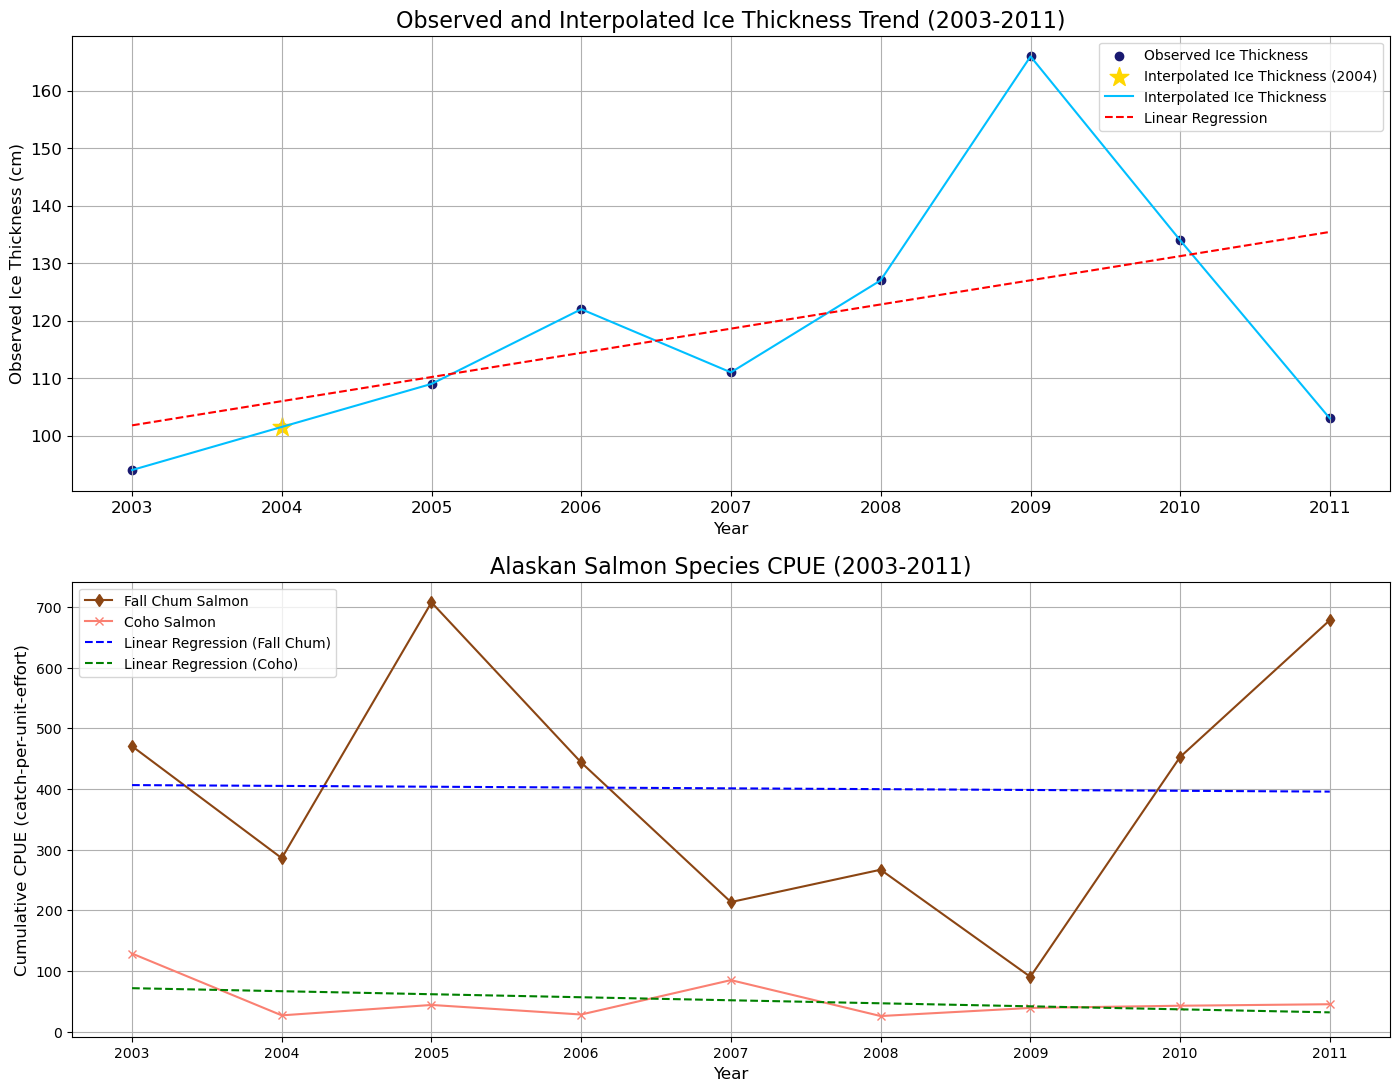

In [13]:
# make and display figure
fig, axs = plt.subplots(figsize=(17, 13), nrows=2)

#scatter plot for observed ice thickness
axs[0].scatter(shageluk_df.index, shageluk_df["ObservedIceThickness"],
            c="midnightblue", marker="o", label="Observed Ice Thickness")

#highlight the interpolated data point for 2004
axs[0].scatter(shageluk_df.index[1], shageluk_df["ObservedIceThickness"].iloc[1],
            c="gold", marker="*", s=200, label="Interpolated Ice Thickness (2004)")

#plot interpolated data and trendline
axs[0].plot(shageluk_df.index, shageluk_df["ObservedIceThickness"],
         c="deepskyblue", label="Interpolated Ice Thickness")
axs[0].plot(shageluk_df.index, y_values,
         c="red", ls="--", label="Linear Regression")

#plot labels and x ticks ahd legends
axs[0].set_xlabel('Year', fontsize=12)
axs[0].set_ylabel('Observed Ice Thickness (cm)', fontsize=12)
axs[0].set_title('Observed and Interpolated Ice Thickness Trend (2003-2011)', fontsize=16)
axs[0].set_xticks(pd.date_range(start='2003', end='2011', freq='YS'))
axs[0].set_xticklabels(pd.date_range(start='2003', end='2011', freq='YS').year)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].grid()
axs[0].legend()


# salmon population plot (for 2003-2011)
axs[1].plot(fallchum_figure3.index, fallchum_figure3.values,
         c="saddlebrown",marker="d",label="Fall Chum Salmon")
axs[1].plot(coho_figure3.index, coho_figure3.values,
         c="salmon",marker="x",label="Coho Salmon")

#add trendline
axs[1].plot(fallchum_figure3.index.values,y_trend,
            c="blue",ls="--", label="Linear Regression (Fall Chum)")
axs[1].plot(coho_figure3.index.values,y_trend2,
            c="green",ls="--", label="Linear Regression (Coho)")

# Add labels, title, and grid
axs[1].set_title('Alaskan Salmon Species CPUE (2003-2011)', fontsize=16)
axs[1].set_xlabel('Year', fontsize=12)
axs[1].set_ylabel('Cumulative CPUE (catch-per-unit-effort)', fontsize=12)
axs[1].grid()
axs[1].legend()

<!-- Describe how this figure helps address your research question. What patterns or insights can you observe? -->
**Figure 3 Caption:** The top figure shows the ice thickness in Shageluk Lake in the Lower Yukon region, and surprisingly there is an increasing trend for sea ice thickness as opposed to what I thought. The yellow star shows the interpolated value for the missing 2004 data, though it doesn't make a huge difference in the linear regression plotting. The bottom plot shows the annual mean salmon population from 2003-2011 as to match with the year intervals of the Shageluk ice data. The results showed that there is a decreasing trend for both populations when lake ice thickness was increasing, so it was the complete opposite of my hypothesis. 

## Discussion
**Interpretation of Results:** 
<!-- Summarize what you learned from each data analysis section/figure. Discuss key insights and conclusions regarding your research question. Do your results support or contradict your hypothesis? -->
The results of the figures were the opposite of what I thought, they all contradict my hypothesis, other than the sea ice extent decreasing which makes sense due to climate change and warmer temperatures. For figure 1, there was a slight discrepancy between coho and fall chum CPUE since one has a positive linear regression (fall chum) and the other has a negative linear regression (coho). Through the correlation calculation of r^2 values, it didn't show much of a correlation between ice extent and salmon population (since the values are very in between). So moving onto figure 2a and 2b, looking at the seasonality of ice, it is definitely clear that as ice extent decreases, salmon population actually increases, which showed the same results from figure 1. For figure 3, zooming into Shageluk Lake, there was surprisingly an increase in sea ice thickness even though in figure 1 it showed a clear decreasing trend of sea ice extent. However, the salmon population actually showed a negative linear regression as ice thickness increases. So overall, my hypothesis was rejected, and the conclusion is salmon populations increases as sea ice thickness/ extent decreases, vice versa, in Lower Yukon in Alaska. This might be due to less sea ice coverage would make more room for salmon to reproduce and swim upstream/ to open water, thus increasing the salmon population. 

**Limitations and Future Work:** 
<!-- Identify limitations in your analysis. Discuss any factors that may have impacted the validity or reliability of your results (e.g., data quality, sample size, assumptions). -->
<!-- What next steps could you or another researcher take to continue investigating this research question? Suggest ideas for further research, data collection, or alternative methodologies that could enhance understanding of the topic. -->
The data quality of the salmon CPUE is questionable as there is no description to the dataset at all, so I only found out that there were a couple of bad data points ("0" values) when I loaded in the data on a plot. If I could, I would definitely find a better set of salmon count data. But due to the quality of this dataset, the results may have been skewed or doesn't fully represent salmon CPUE throughout the years. I was originally going to do an anomoly comparison instead of just looking at the climatology (part 2), but I thought it might have been a bit too complicated, since I had to redownload the salmon population data since I only had data between 1990-2021 downloaded. That is also why the 30 year intervals are also different, but I tried my best to keep it the same time length since it's already different in regards to time period (with roughly a 10-year-difference). But this is definitely something interesting to look at if I had more time, or maybe I could continue to work on this project in the future. 

## References  

<!--Cite all papers, websites, or other resources you referenced in your project. Use a consistent citation style (e.g., APA, MLA, Chicago).-->

1. “Sea Ice Index, Version 3.” National Snow and Ice Data Center, 5 Mar. 2021, nsidc.org/data/g02135/versions/3#anchor-documentation, https://doi.org/10.7265/N5K072F8. Accessed 6 Dec. 2024.

2. Arp, Christopher , and Jessica Cherry. “Seasonal Maximum Ice Thickness Data for Rivers and Lakes in Alaska from 1962 to 2019.” NSF Arctic Data Center, 2020, arcticdata.io/catalog/view/doi%3A10.18739%2FA26688J9Z. Accessed 6 Dec. 2024.

3. dfg.webmaster@alaska.gov. “Yukon Test Fish Inseason and Historical Data, Alaska Department of Fish and Game.” Alaska.gov, 2023, www.adfg.alaska.gov/index.cfm?adfg=commercialbyareayukon.salmon_testfishdata. Accessed 6 Dec. 2024.